In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib

In [49]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
print(tf.__version__)


2.6.0


In [13]:
data_dir = pathlib.Path("/home/divyanshu/Documents/Data Science/Datasets/catvsdog/training_set")

In [14]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

8005


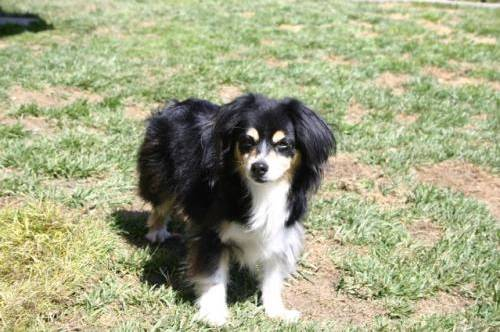

In [15]:
dogs = list(data_dir.glob('dogs/*'))
PIL.Image.open(str(dogs[0]))


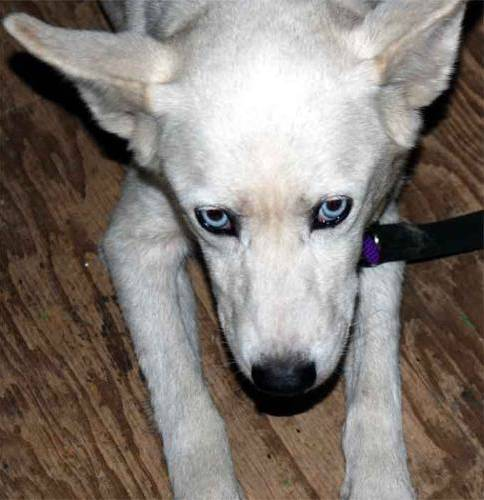

In [16]:
PIL.Image.open(str(dogs[1]))

In [17]:
batch_size = 32
img_height = 96
img_width = 96

In [18]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8005 files belonging to 2 classes.
Using 6404 files for training.


2021-11-19 12:25:17.482999: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-19 12:25:17.483339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-19 12:25:17.483847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-19 12:25:17.484163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [19]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8005 files belonging to 2 classes.
Using 1601 files for validation.


In [20]:
class_names = train_ds.class_names
print(class_names)


['cats', 'dogs']


2021-11-19 12:25:49.793275: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


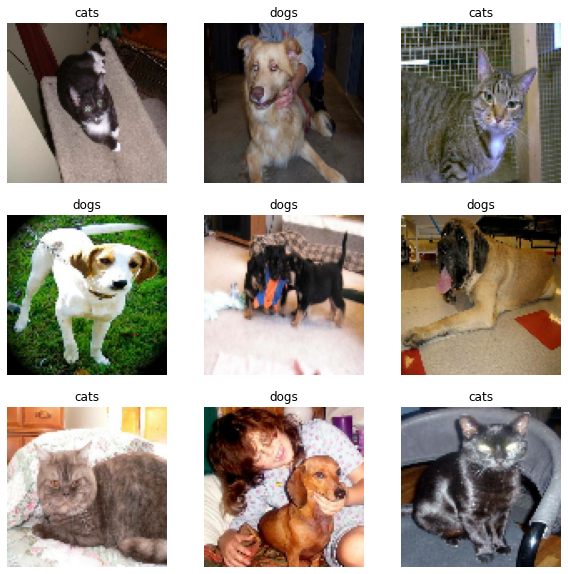

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [22]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 96, 96, 3)
(32,)


In [23]:
from tensorflow.keras import layers
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [26]:
IMG_SHAPE = (img_height,img_width) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [27]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


2021-11-19 12:26:21.078101: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-11-19 12:26:26.706542: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202
2021-11-19 12:26:32.433360: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


(32, 3, 3, 1280)


In [28]:
base_model.trainable = False


In [29]:
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
________________________________________________________________________________

In [30]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [31]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [32]:
inputs = tf.keras.Input(shape=(96, 96, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [33]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


/home/divyanshu/tfenv/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [34]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

In [35]:
len(model.trainable_variables)

2

In [36]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

51/51 [==============================] - 27s 385ms/step - loss: 0.7972 - accuracy: 0.5815


In [37]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.80
initial accuracy: 0.58


In [38]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
201/201 [==============================] - 92s 440ms/step - loss: 0.4737 - accuracy: 0.7488 - val_loss: 0.3101 - val_accuracy: 0.8720
Epoch 2/10
201/201 [==============================] - 22s 108ms/step - loss: 0.2493 - accuracy: 0.8905 - val_loss: 0.2167 - val_accuracy: 0.9144
Epoch 3/10
201/201 [==============================] - 22s 107ms/step - loss: 0.1867 - accuracy: 0.9238 - val_loss: 0.1810 - val_accuracy: 0.9313
Epoch 4/10
201/201 [==============================] - 22s 110ms/step - loss: 0.1553 - accuracy: 0.9396 - val_loss: 0.1614 - val_accuracy: 0.9350
Epoch 5/10
201/201 [==============================] - 22s 110ms/step - loss: 0.1407 - accuracy: 0.9444 - val_loss: 0.1495 - val_accuracy: 0.9400
Epoch 6/10
201/201 [==============================] - 23s 114ms/step - loss: 0.1337 - accuracy: 0.9447 - val_loss: 0.1413 - val_accuracy: 0.9419
Epoch 7/10
201/201 [==============================] - 22s 111ms/step - loss: 0.1217 - accuracy: 0.9524 - val_loss: 0.1354 - val_ac

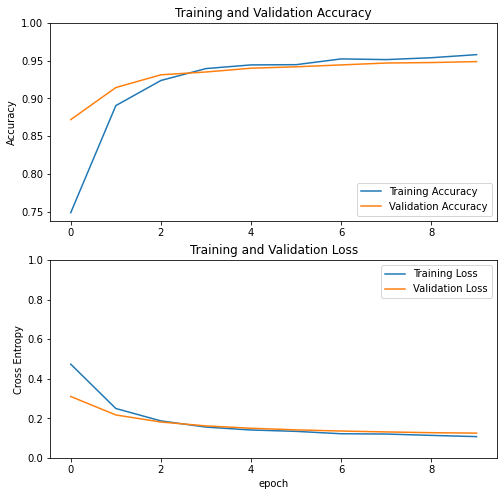

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [41]:
test_dir= pathlib.Path("/home/divyanshu/Documents/Data Science/Datasets/catvsdog/test_set")

In [42]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2023 files belonging to 2 classes.


In [43]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

64/64 [==============================] - 13s 154ms/step - loss: 0.1111 - accuracy: 0.9565
Test accuracy : 0.956500232219696


Predictions:
 [0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1]
Labels:
 [0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1]


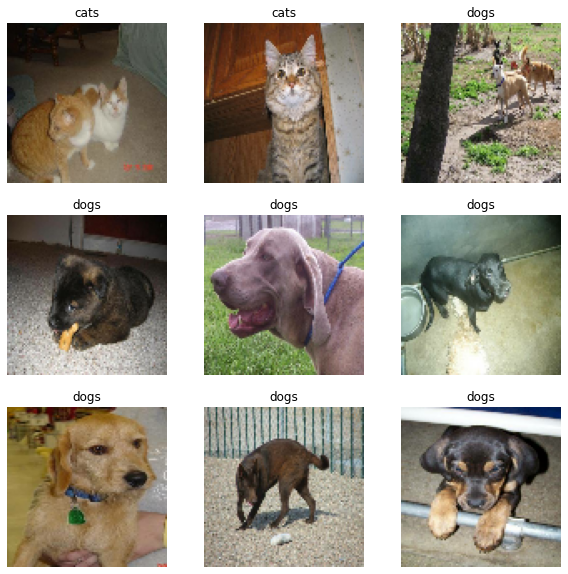

In [44]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
